In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize']=10,6
import matplotlib.pyplot as plt

In [14]:
columns=[
'vendor name',
'Model Name',
'MYCT', 
'MMIN', 
'MMAX',
'CACH',
'CHMIN', 
'CHMAX', 
'PRP', 
'ERP', 
]

Attribute Information:
1. vendor name: 30 (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

In [51]:
df=pd.read_csv('./hardware.csv', names=columns)

In [52]:
df.head()

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [53]:
df.columns

Index(['vendor name', 'Model Name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN',
       'CHMAX', 'PRP', 'ERP'],
      dtype='object')

In [54]:
df=df.rename(columns={'PRP' : 'Target'}).drop(['vendor name', 'Model Name', 'ERP'], axis=1)

In [55]:
df.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Target
0,125,256,6000,256,16,128,198
1,29,8000,32000,32,8,32,269
2,29,8000,32000,32,8,32,220
3,29,8000,32000,32,8,32,172
4,29,8000,16000,32,8,16,132


In [23]:
import seaborn as sns

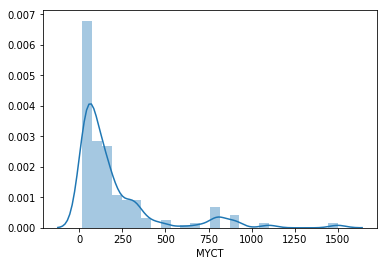

In [24]:
sns.distplot(df.MYCT)

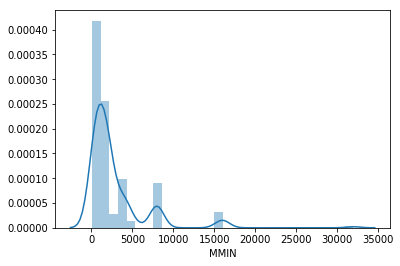

In [25]:
sns.distplot(df.MMIN)

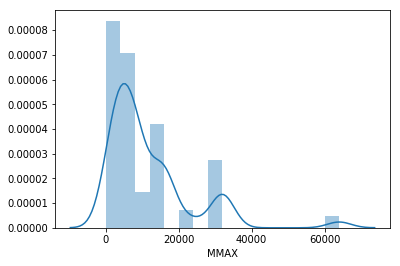

In [26]:
sns.distplot(df.MMAX)

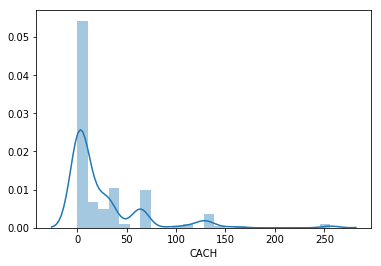

In [27]:
sns.distplot(df.CACH)

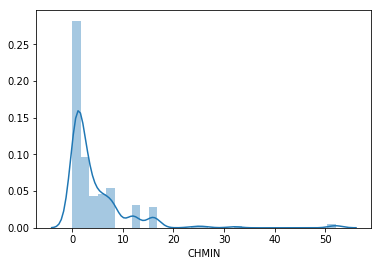

In [28]:
sns.distplot(df.CHMIN)

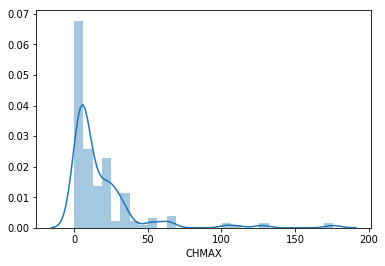

In [29]:
sns.distplot(df.CHMAX)

In [30]:
from sklearn.preprocessing import StandardScaler

In [48]:
from sklearn.model_selection import train_test_split

In [63]:
data_train, data_test, _, _ = train_test_split(df, df.Target, test_size=0.2)

In [68]:
data_train.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,Target
181,240,512,1000,8,1,3,6
83,330,1000,2000,0,1,2,16
105,400,2000,4000,0,1,1,32
152,35,8000,32000,64,8,24,370
122,1500,768,1000,0,0,0,12


In [70]:
scaler=StandardScaler()
data_train_=np.hstack((scaler.fit_transform(data_train.drop('Target', axis=1)), np.array([data_train.Target.values]).T))
data_test_=np.hstack((scaler.transform(data_test.drop('Target', axis=1)), np.array([data_test.Target.values]).T))

C:\Users\VISHAL\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\VISHAL\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\VISHAL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
data_train_=pd.DataFrame(data_train_, columns=columns[2:8]+['Target'])
data_test_=pd.DataFrame(data_test_, columns=columns[2:8]+['Target'])

In [65]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'Target ~ ' + ' + '.join(['%s' % variable for variable in data_train.columns[:-1]])
formula

'Target ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX'

In [61]:
import pymc3 as pm

In [75]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = data_train_, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 1000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, CHMAX, CHMIN, CACH, MMAX, MMIN, MYCT, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:15<00:00, 198.80it/s]


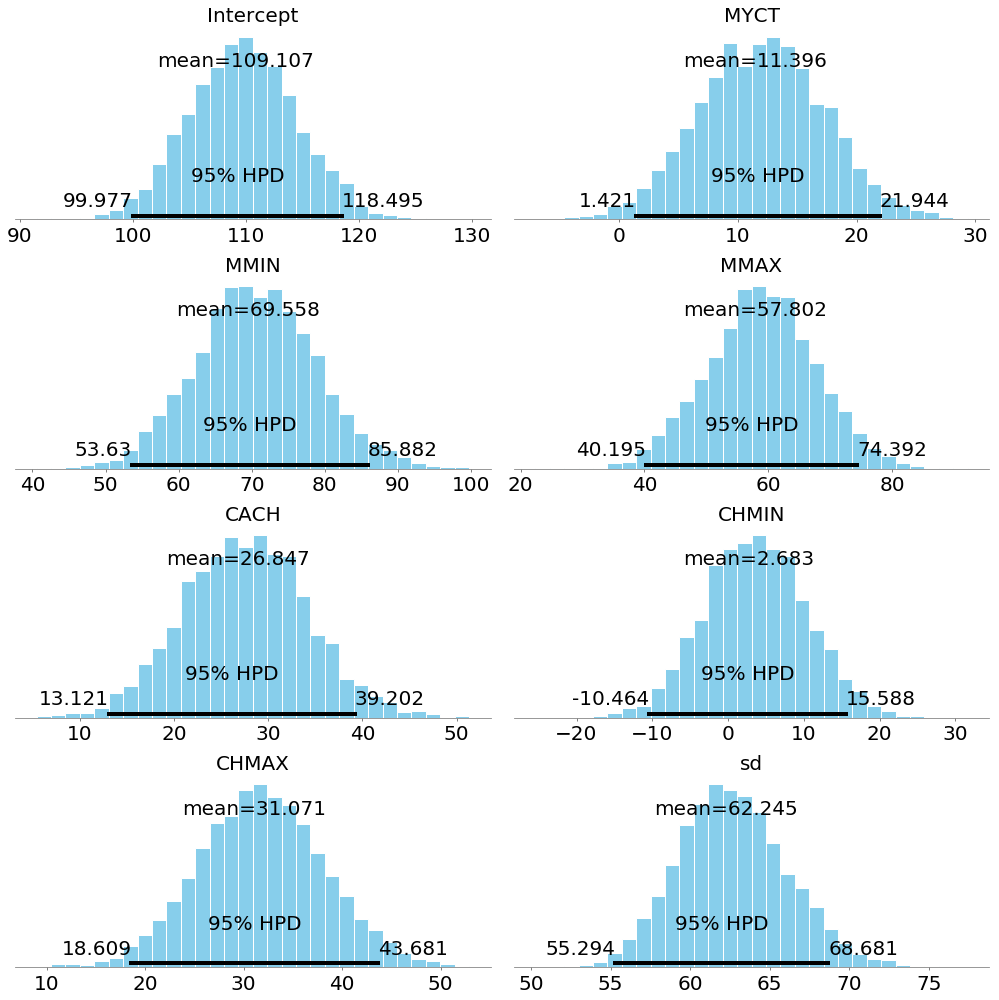

In [76]:
pm.plot_posterior(normal_trace, figsize = (14, 14), text_size=20);